In [24]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sys
import os

os.chdir(os.path.abspath(''))
sys.path.append(os.path.abspath(os.path.abspath('')))
sys.path.append(os.path.abspath(os.path.abspath('') + '/src'))

from utils import *
from layers import *
from models import *

import pandas as pd
import numpy as np

import seaborn as sns
from ing_theme_matplotlib import mpl_style # pip install ing_theme_matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt

df_train_total = pd.read_csv("../data/df_train_total.csv")
df_test_total = pd.read_csv("../data/df_test_total.csv")
df_merged = pd.read_csv("../data/df_merged.csv")
df_train_total
train_conti_input, train_cate_input, train_future_input, train_label = generate_ts_data(df_train_total, df_merged)
test_conti_input, test_cate_input, test_future_input, test_label = generate_ts_data(df_test_total, df_merged)

eval_a, eval_b, eval_c, eval_d, eval_e = generate_eval_ts(df_test_total, df_merged, input_seq_len=48, tau=12)

In [25]:
eval_conti = torch.FloatTensor(eval_a)
eval_cate = torch.LongTensor(eval_b)
eval_future = torch.LongTensor(eval_c)
eval_label = torch.FloatTensor(eval_d)
eval_past_label = torch.FloatTensor(eval_e)

In [26]:
tft = TemporalFusionTransformer(
    d_model=30,
    d_embedding=5,
    cate_dims=[16, 32, 24],
    num_cv=16,
    seq_len=48,
    num_targets=1,
    tau=12,
    quantile=[0.1, 0.3, 0.5, 0.7, 0.9],
    dr=0.1,
    device=device
)
                
deepar = DeepAR(
        d_input=16, 
        d_embedding=3, 
        n_embedding=[16, 32, 24], 
        d_model=30, 
        num_targets=1, 
        n_layers=3,
        dr=0.1
    )

mqrnn = MQRnn(
        d_input=16,
        d_embedding=1,
        n_embedding=[16, 32, 24],
        d_model=5,
        tau=12,
        num_targets=1,
        num_quantiles=5,
        n_layers=3,
        dr=0.1
    )

mqrnn.load_state_dict(torch.load("../assets/MQRnn.pth", map_location="cpu"))
deepar.load_state_dict(torch.load("../assets/DeepAR.pth", map_location='cpu'))
tft.load_state_dict(torch.load("../assets/TFT.pth", map_location="cpu"))

/opt/homebrew/Caskroom/miniforge/base/envs/ts/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [27]:
deepar.eval()
output_deepar = deepar(eval_conti, eval_cate, eval_future)
output_deepar_mu, output_deepar_sigma = output_deepar
output_deepar_mu.detach().cpu().numpy()
output_deepar_mu.shape
deepar_output = gaussian_quantile(output_deepar_mu, output_deepar_sigma)

In [28]:
mqrnn.eval()
mqrnn_output = mqrnn(eval_conti, eval_cate, eval_future)

In [29]:
tft.eval()
tft_output = tft(eval_conti, eval_cate, eval_future)

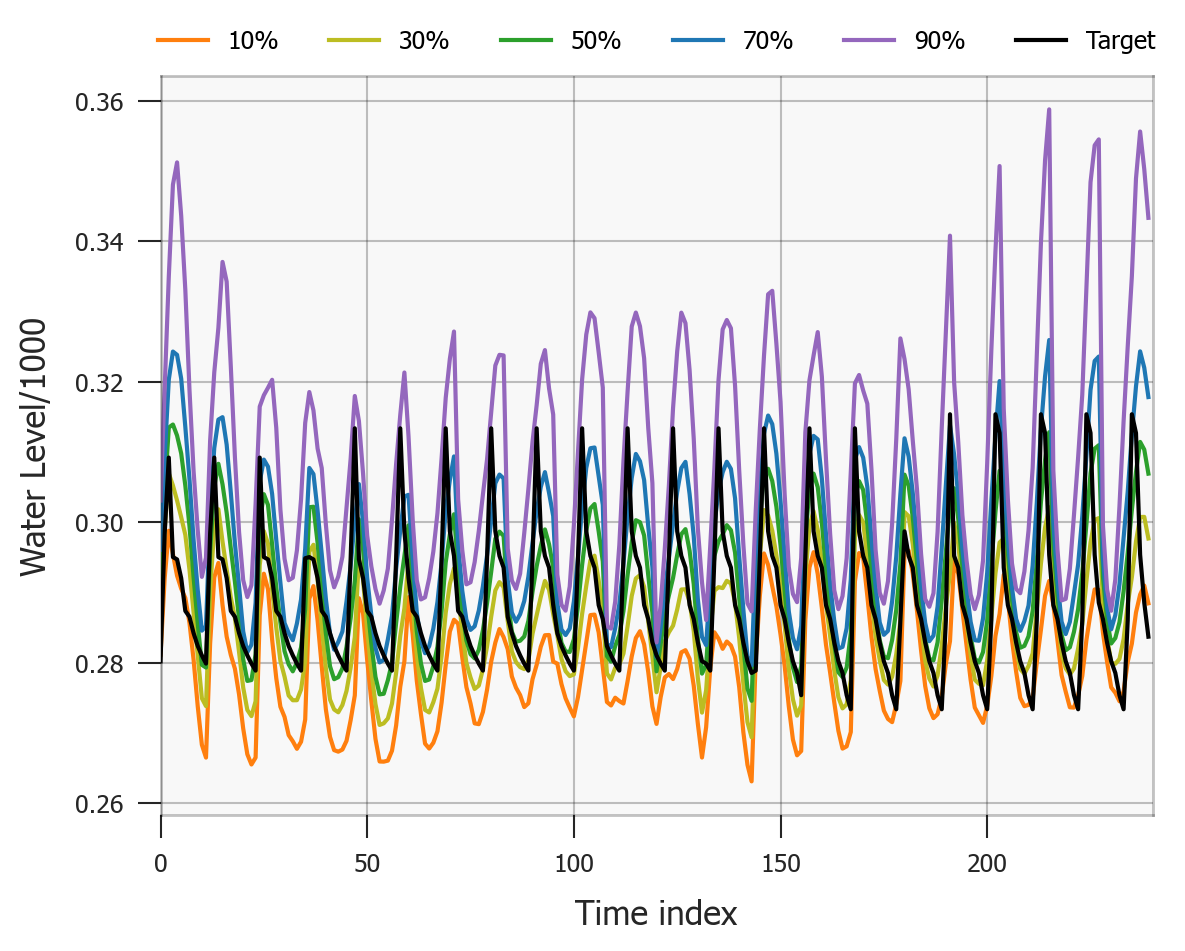

In [30]:
plot_results(eval_label[150:170], mqrnn_output[150:170], dark=False)

In [31]:
sps = torch.tensor([ [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                    [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
                ).float()

In [32]:
instatran = InstaTran(
    d_model=10,
    d_embedding=3,
    cate_dims=[16, 32, 24],
    spatial_structure=sps,
    num_cv=16,
    seq_len=48,
    num_targets=1,
    tau=12,
    quantile=[0.1, 0.3, 0.5, 0.7, 0.9],
    dr=0.1,
    device=device
)

/opt/homebrew/Caskroom/miniforge/base/envs/ts/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [33]:
instatran_wo_sps = InstaTran(
    d_model=10,
    d_embedding=3,
    cate_dims=[16, 32, 24],
    spatial_structure=None,
    num_cv=16,
    seq_len=48,
    num_targets=1,
    tau=12,
    quantile=[0.1, 0.3, 0.5, 0.7, 0.9],
    dr=0.1,
    device=device
)

In [34]:
instatran.load_state_dict(torch.load("../assets/InstaTran.pth", map_location='cpu'))

<All keys matched successfully>

In [35]:
instatran_wo_sps.load_state_dict(torch.load("../assets/InstaTran_wo_sps.pth", map_location='cpu'))


<All keys matched successfully>

In [36]:
mpl.rcParams["figure.dpi"] = 100
mpl_style(dark=False)


Text(0, 0.5, 'Variable index')

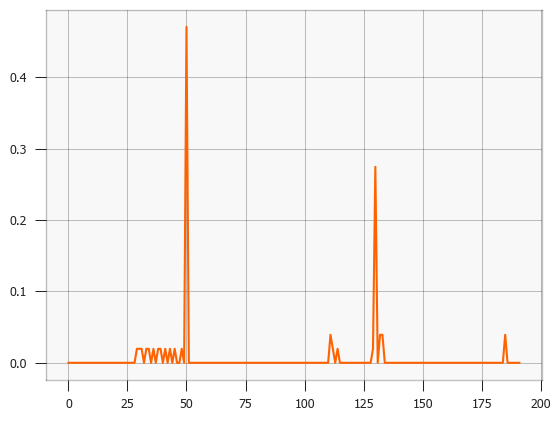

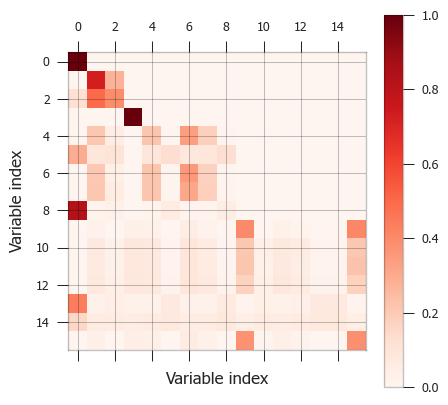

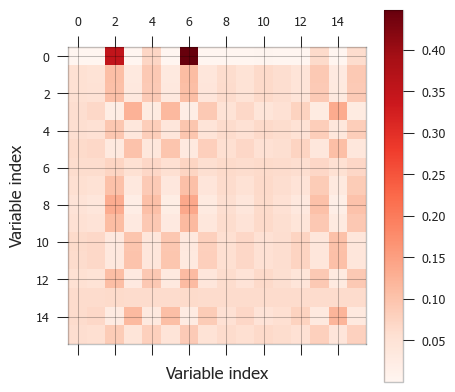

In [37]:
eval_conti = torch.FloatTensor(eval_a[1500:1650])
eval_cate = torch.LongTensor(eval_b[1500:1650])
eval_future = torch.LongTensor(eval_c[1500:1650])
eval_label = torch.FloatTensor(eval_d[1500:1650])
eval_past_label = torch.FloatTensor(eval_e[1500:1650])

instatran.eval()
output, ssa_weight1, ssa_weight2, tsa_weight, dec_weights, fi1, fi2 = instatran(eval_conti, eval_cate, eval_future)

instatran_wo_sps.eval()
output_no_sps, ssa_weight1_no_sps, ssa_weight2_no_sps, tsa_weight_no_sps, dec_weights_no_sps, fi1_no_sps, fi2_no_sps = instatran_wo_sps(eval_conti, eval_cate, eval_future)

batch_num = 50
time_step = 0

plt.plot(eval_conti[::48, :, 0].reshape(-1))
plt.matshow(ssa_weight1[batch_num, time_step, ...].detach().numpy(), cmap='Reds')
plt.xlabel("Variable index")
plt.ylabel("Variable index")
plt.colorbar()

plt.matshow(ssa_weight1_no_sps[batch_num, time_step, ...].detach().numpy(), cmap='Reds')
plt.colorbar()
plt.xlabel("Variable index")
plt.ylabel("Variable index")

In [38]:
tft.eval()
confe_output = tft.confe(eval_conti) 
catfe_output = tft.catfe(eval_cate)  
obs_feature = torch.cat([confe_output, catfe_output], axis=-2)  
x1, tft_vsn_output  = tft.vsn1(obs_feature) 

In [39]:
instatran.eval()
instatran_output, ssa_weight1, ssa_weight2, tsa_weight, dec_weights, fi1, fi2  = instatran(eval_conti, eval_cate, eval_future)

<Axes: xlabel='Time points'>

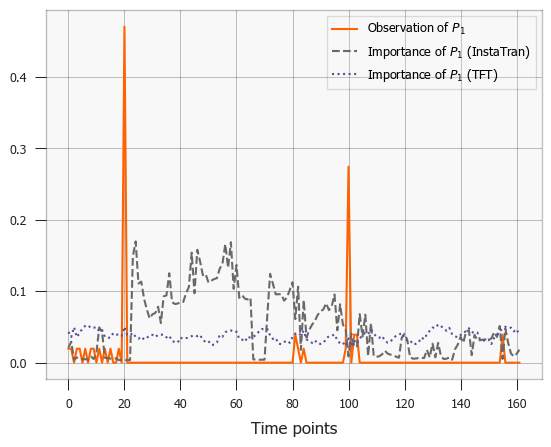

In [40]:
ax = sns.lineplot(eval_conti.cpu()[::48, :, 0].squeeze().reshape(-1)[30:], label=r"Observation of $P_1$").set(xlabel="Time points")
sns.lineplot(fi1.detach().cpu()[::48, :, 0, 0].reshape(-1)[30:], linestyle='--', label=r"Importance of $P_1$ (InstaTran)")
# sns.lineplot(fi1.detach().cpu()[::48, :, 11, 0].reshape(-1)[30:], label="WL(JS)")
sns.lineplot(tft_vsn_output.detach().cpu()[::48, :, 0, 0].reshape(-1)[30:], linestyle=':', label=r"Importance of $P_1$ (TFT)")

<Axes: xlabel='Time points'>

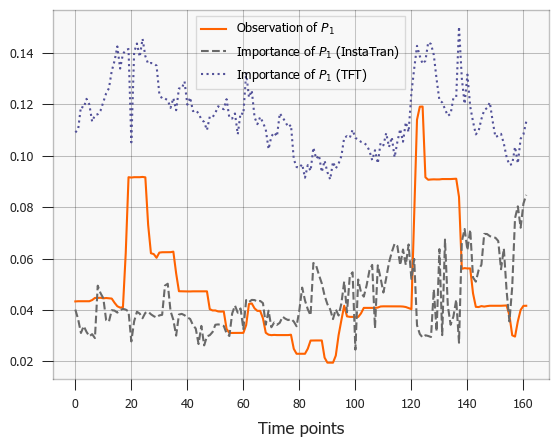

In [41]:
feature_idx = 8
importance_mat = np.zeros((150, 197))
for i in range(150):
    importance_mat[i, i:i+48] = fi1.detach().cpu()[i, :, feature_idx, 0]


tft_importance_mat = np.zeros((150, 197))
for i in range(150):
    tft_importance_mat[i, i:i+48] = tft_vsn_output.detach().cpu()[i, :, feature_idx, 0]

ax = sns.lineplot(eval_conti.cpu()[::48, :, feature_idx].squeeze().reshape(-1)[30:], label=r"Observation of $P_1$").set(xlabel="Time points")
sns.lineplot(np.nanmean(np.where(importance_mat==0.0, np.nan, importance_mat), axis=0)[30:-5], linestyle='--', label=r"Importance of $P_1$ (InstaTran)")
sns.lineplot(np.nanmean(np.where(tft_importance_mat==0.0, np.nan, tft_importance_mat), axis=0)[30:-5], linestyle=':', label=r"Importance of $P_1$ (TFT)")

In [42]:
eval_conti = torch.FloatTensor(eval_a)
eval_cate = torch.LongTensor(eval_b)
eval_future = torch.LongTensor(eval_c)
eval_label = torch.FloatTensor(eval_d)
eval_past_label = torch.FloatTensor(eval_e)

instatran_output, ssa_weight1, ssa_weight2, tsa_weight, dec_weights, fi1, fi2  = instatran(eval_conti, eval_cate, eval_future)

Text(26.4, 0.0265, '(12 hours)')

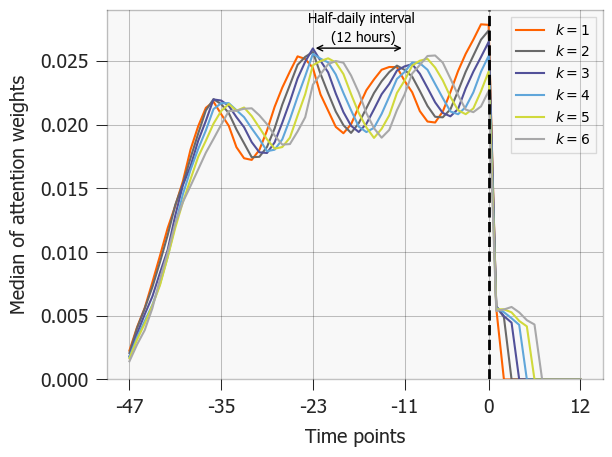

In [43]:
mpl.rcParams["figure.dpi"] = 100
mpl_style(dark=False)
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#%%
g = sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 48, ], 0.5, axis=0), label=r"$k = 1$")
g.set_ylim(0, 0.029)
g.set_xticks([0, 12, 24, 36, 47, 59], ["-47", "-35", "-23", "-11", "0", "12"])
g.set_xlabel("Time points")
g.set_ylabel("Median of attention weights")
sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 49, ], 0.5, axis=0), label=r"$k = 2$")
sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 50, ], 0.5, axis=0), label=r"$k = 3$")
sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 51, ], 0.5, axis=0), label=r"$k = 4$")
sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 52, ], 0.5, axis=0), label=r"$k = 5$")
sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 53, ], 0.5, axis=0), label=r"$k = 6$")
g.axvline(47,  linestyle='--', linewidth=2, color='k')
# g.axvline(11,  linestyle=':', linewidth=2, color='k')
# g.axvline(23,  linestyle=':', linewidth=2, color='k')
# g.axvline(35,  linestyle=':', linewidth=2, color='k')
xstart = 24
ystart = 0.026
g.annotate("",
            xy=(xstart, ystart),
            xytext=(xstart+12, ystart),
            va="center",
            ha="center",
            arrowprops=dict(color='black', arrowstyle="<->"))
g.annotate("Half-daily interval", xy=(xstart-4, ystart+0.002), xytext=(xstart-0.7, ystart+0.002), color='black')
g.annotate("(12 hours)", xy=(xstart, ystart+0.0005), xytext=(xstart+2.4, ystart+0.0005), color='black')

Text(30.4, 0.0265, '(12 hours)')

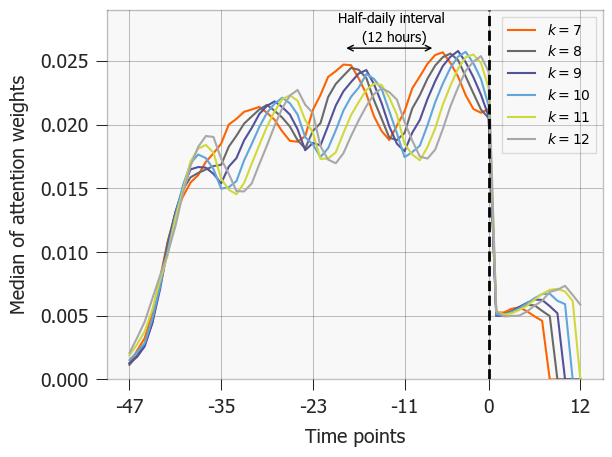

In [44]:
g = sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 54, :], 0.5, axis=0), label=r"$k = 7$")
g.set_ylim(0, 0.029)
g.set_xticks([0, 12, 24, 36, 47, 59], ["-47", "-35", "-23", "-11", "0", "12"])
g.set_xlabel("Time points")
g.set_ylabel("Median of attention weights")
sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 55, :], 0.5, axis=0), label=r"$k = 8$")
sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 56, :], 0.5, axis=0), label=r"$k = 9$")
sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 57, :], 0.5, axis=0), label=r"$k = 10$")
sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 58, :], 0.5, axis=0), label=r"$k = 11$")
sns.lineplot(np.quantile(dec_weights.detach().numpy()[:, 59, :], 0.5, axis=0), label=r"$k = 12$")
g.axvline(47,  linestyle='--', linewidth=2, color='k')
xstart = 28
ystart = 0.026
g.annotate("",
            xy=(xstart, ystart),
            xytext=(xstart+12, ystart),
            va="center",
            ha="center",
            arrowprops=dict(color='black', arrowstyle="<->"))
g.annotate("Half-daily interval", xy=(xstart-4, ystart+0.002), xytext=(xstart-0.7, ystart+0.002), color='black')
g.annotate("(12 hours)", xy=(xstart, ystart+0.0005), xytext=(xstart+2.4, ystart+0.0005), color='black')